In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


[nltk_data] Downloading package stopwords to C:\Users\ROGITH
[nltk_data]     GOUD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

# Load dataset
df = pd.read_csv("data/Reviews.csv")


In [3]:
# Keep only non-neutral reviews
df = df[df['Score'] != 3]

# Map scores to binary labels
df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

In [12]:
df_sample = df.sample(10000, random_state=42)

X_text = df_sample['Text'].values
y = df_sample['label'].values.reshape(-1,1)


In [26]:
stopwords_english = stopwords.words('english')
stemmer = PorterStemmer()


In [33]:
from collections import defaultdict
import re
import numpy as np

def process_review(review):
    review = review.lower()
    words = re.findall(r'\b\w+\b', review)
    clean_words = [stemmer.stem(w) for w in words if w not in stopwords_english]
    return clean_words

def build_freqs(reviews, labels):
    freqs = defaultdict(int)
    labels = labels.flatten()   # <---- ensures 1D array of ints
    for label, review in zip(labels, reviews):
        for word in process_review(review):
            freqs[(word, label)] += 1
    return freqs


def extract_features(review, freqs):
    words = process_review(review)
    x = np.zeros(3)
    x[0] = 1  # bias term
    for word in words:
        x[1] += freqs.get((word, 1), 0)
        x[2] += freqs.get((word, 0), 0)
    return x.reshape(1, -1)


In [34]:
train_x, test_x, train_y, test_y = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)

# build frequency dictionary only from training data
freqs = build_freqs(train_x, train_y)

# convert train and test data to features
X_train = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X_train[i, :] = extract_features(train_x[i], freqs)

X_test = np.zeros((len(test_x), 3))
for i in range(len(test_x)):
    X_test[i, :] = extract_features(test_x[i], freqs)

In [ ]:
#Logistic Regression Implementation

In [35]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [36]:
def gradientDescent(x, y, theta, alpha, num_iters):
    m = len(y)
    for i in range(num_iters):
        z = np.dot(x, theta)
        h = sigmoid(z)
        J = - (1/m) * np.sum(y*np.log(h+1e-9) + (1-y)*np.log(1-h+1e-9))
        theta -= (alpha/m) * np.dot(x.T, (h - y))
        if i % 200 == 0:
            print(f"Iteration {i}: cost {J:.4f}")
    return J, theta

In [37]:
theta = np.zeros((3,1))
J, theta = gradientDescent(X_train, train_y, theta, alpha=1e-9, num_iters=2000)

print("Final cost:", J)
print("Theta:", theta)

Iteration 0: cost 0.6931
Iteration 200: cost 0.5440
Iteration 400: cost 0.5407
Iteration 600: cost 0.5374
Iteration 800: cost 0.5342
Iteration 1000: cost 0.5310
Iteration 1200: cost 0.5279
Iteration 1400: cost 0.5249
Iteration 1600: cost 0.5219
Iteration 1800: cost 0.5190
Final cost: 0.5161156491037546
Theta: [[ 2.63389630e-07]
 [ 8.70438399e-05]
 [-2.38616658e-04]]


In [38]:
# 5. Evaluation
# ---------------------------
def predict_review(review, freqs, theta):
    x = extract_features(review, freqs)
    return sigmoid(np.dot(x, theta))

# accuracy on test set
y_hat = []
for review in test_x:
    y_pred = predict_review(review, freqs, theta)
    y_hat.append(1 if y_pred > 0.5 else 0)

accuracy = np.mean((np.array(y_hat) == test_y.flatten())) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 83.65%


In [39]:
import pandas as pd

def freqs_to_dataframe(freqs):
    data = []
    for (word, label), count in freqs.items():
        data.append([word, label, count])
    df_freqs = pd.DataFrame(data, columns=["word", "label", "count"])
    return df_freqs

df_freqs = freqs_to_dataframe(freqs)


In [40]:
pos_words = df_freqs[df_freqs["label"] == 1].sort_values(by="count", ascending=False)
neg_words = df_freqs[df_freqs["label"] == 0].sort_values(by="count", ascending=False)

print("🔹 Top Positive Words:\n", pos_words.head(20))
print("\n🔻 Top Negative Words:\n", neg_words.head(20))


🔹 Top Positive Words:
         word  label  count
361       br      1   7125
301     like      1   3094
65      tast      1   2917
5     flavor      1   2656
29      good      1   2609
0       love      1   2518
4      great      1   2307
128      one      1   2218
129  product      1   2136
61       use      1   2133
1        tea      1   2058
18       tri      1   2028
591    coffe      1   1985
88      food      1   1782
106      get      1   1609
68      make      1   1527
47    amazon      1   1326
815      dog      1   1289
92      time      1   1285
359    would      1   1268

🔻 Top Negative Words:
          word  label  count
774        br      0   1544
151      like      0    769
766      tast      0    754
126   product      0    591
195    flavor      0    452
119     would      0    427
168       one      0    416
1033      tri      0    394
191     coffe      0    386
1328     food      0    357
116      good      0    317
768       use      0    302
149       buy      0  

Matplotlib is building the font cache; this may take a moment.


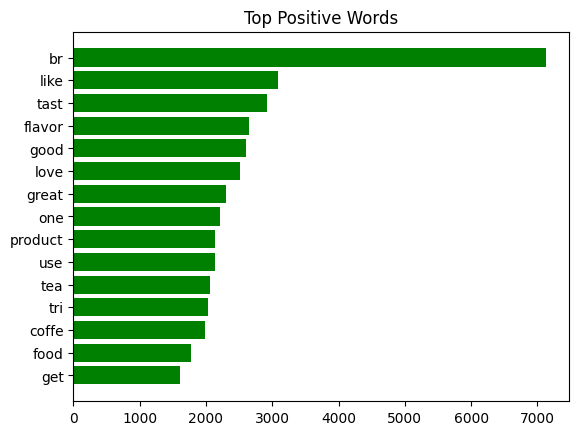

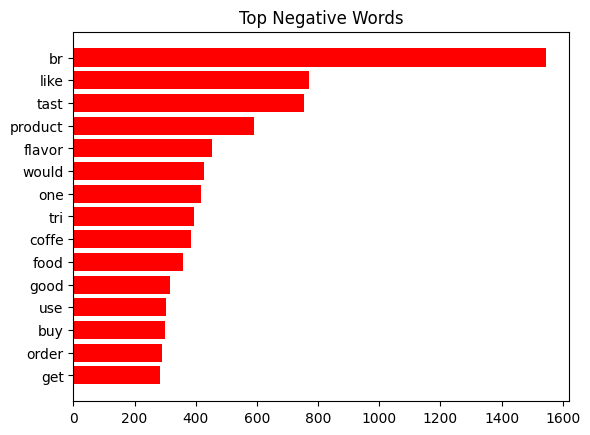

In [41]:
import matplotlib.pyplot as plt

# top 15 positive words
top_pos = pos_words.head(15)
plt.barh(top_pos["word"], top_pos["count"], color="green")
plt.title("Top Positive Words")
plt.gca().invert_yaxis()
plt.show()

# top 15 negative words
top_neg = neg_words.head(15)
plt.barh(top_neg["word"], top_neg["count"], color="red")
plt.title("Top Negative Words")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
#Naive Bayes Implementation

In [42]:
import numpy as np

def train_naive_bayes(freqs, train_y):
    """
    Input:
      freqs: dictionary of (word, label) -> count
      train_y: list/array of labels (0 or 1) for training data
    Output:
      logprior: float
      loglikelihood: dictionary of word -> log(P(word|pos)/P(word|neg))
    """
    loglikelihood = {}

    # total number of positive and negative words
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    N_pos = N_neg = 0  # total counts
    for (word, label), cnt in freqs.items():
        if label == 1:
            N_pos += cnt
        else:
            N_neg += cnt

    # number of positive and negative documents
    D = len(train_y)
    D_pos = np.sum(train_y)
    D_neg = D - D_pos

    # logprior
    logprior = np.log(D_pos / D_neg)

    # likelihoods
    for word in vocab:
        # positive and negative counts of the word
        freq_pos = freqs.get((word, 1), 0)
        freq_neg = freqs.get((word, 0), 0)

        # Laplace smoothing
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # loglikelihood
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)

    return logprior, loglikelihood


In [43]:
def naive_bayes_predict(review, logprior, loglikelihood, process_tweet):
    """
    Input:
      review: string
      logprior: float
      loglikelihood: dict of word -> log odds
      process_tweet: preprocessing function
    Output:
      prediction: 1 (positive) or 0 (negative)
    """
    # preprocess
    words = process_tweet(review)

    # start with prior
    score = logprior

    # add loglikelihoods
    for word in words:
        if word in loglikelihood:
            score += loglikelihood[word]

    return 1 if score > 0 else 0


In [47]:
def evaluate_naive_bayes(test_x, test_y, logprior, loglikelihood, process_tweet):
    y_hat = []
    for review in test_x:
        pred = naive_bayes_predict(review, logprior, loglikelihood, process_tweet)
        y_hat.append(pred)

    accuracy = np.mean(np.array(y_hat) == np.array(test_y))
    return accuracy
logprior, loglikelihood = train_naive_bayes(freqs, train_y)
accuracy_nb = evaluate_naive_bayes(test_x, test_y, logprior, loglikelihood, process_review)
print(f"Naive Bayes Test Accuracy: {accuracy_nb*100:.2f}%")


Naive Bayes Test Accuracy: 78.33%
